In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import re
import nltk
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

pd.options.display.max_columns = 50

# DATA

https://www.kaggle.com/olistbr/brazilian-ecommerce

<b>Ответим на вопросы:</b><br/>
Можно ли по отзыву предсказать оценку?<br/>
О чем пишут в отзывах?<br/>

In [2]:
# загрузим необходмые таблицы
tables = [
    'order_payments',
    'order_reviews',
    'orders',
    'products',
    'sellers'
]

for table in tables:
    tmp = pd.read_csv(r'input/brazilian-ecommerce/olist_'+table+'_dataset.csv')
    exec('{} = tmp.copy()'.format(table))
    print('-------------------------',table)
    exec('print({}.columns)'.format(table))
    print()

------------------------- order_payments
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

------------------------- order_reviews
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

------------------------- orders
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

------------------------- products
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

------------------------- sellers
Index(['seller_id', 'sell

### Data Schema

<img src=https://i.imgur.com/HRhd2Y0.png>

## order_reviews

In [3]:
order_reviews.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [4]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
# проверим количество ревью на одном заказе
# если оценка менялась, то стандартное отклонение будет отлично от нуля
sample_order_reviews = \
    order_reviews[['order_id','review_score','review_comment_message']] \
    .groupby(['order_id'],as_index=False) \
    .agg({'review_score':np.std,'review_comment_message':list}) \
    .sort_values(by='review_score', ascending=False)

# комментарии слепим в список и посчитаем длину списка
sample_order_reviews['review_comment_message'] = \
    sample_order_reviews['review_comment_message'] \
    .apply(lambda x: list(set(x)))

sample_order_reviews['len_review_comment_message'] = \
    sample_order_reviews['review_comment_message'] \
    .apply(lambda x: len(x))

# выведем все заказы с более одним ревью, 
# с условием, что оценка менялась или был изменен комментарий
orders_list = list(
    sample_order_reviews.loc[
        (sample_order_reviews['review_score']>0)|
        (sample_order_reviews['len_review_comment_message']>1),
        'order_id']
)

tmp = order_reviews[order_reviews['order_id'].isin(orders_list)] \
        .sort_values(by=['order_id','review_answer_timestamp'], ascending=False)

print(tmp.shape)
display(tmp)

(639, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anu...",2017-08-22 00:00:00,2017-08-25 11:40:22
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16 00:00:00,2017-08-17 11:56:55
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18 00:00:00,2017-11-18 09:02:48
94504,c56a88a404315a0d9e412c1472dda2c4,ff763b73e473d03c321bcd5a053316e8,5,NaN,NaN,2017-11-01 00:00:00,2017-11-01 19:55:52
9898,117b4a19af2b247561f0075f73d6eea1,fe041ba1c9f54016432fa6ee91709dbc,5,NaN,NaN,2017-12-20 00:00:00,2017-12-20 22:04:37
42177,9da0796858da97acd8b67578388a3241,fe041ba1c9f54016432fa6ee91709dbc,5,NaN,"O cartucho está estourado (vazando), já contat...",2017-12-20 00:00:00,2017-12-20 22:03:18
80631,c509f8b367ee5227700c29fcc76a097a,fd95ae805c63c534f1a64589e102225e,5,NaN,"Recebi dentro do prazo estabelecido, produtos ...",2018-03-04 00:00:00,2018-03-06 10:10:08
51459,eba9ae334beb044f1045c073555df70e,fd95ae805c63c534f1a64589e102225e,5,NaN,"Produtos entregues no prazo, excelente qualidade",2018-03-01 00:00:00,2018-03-04 01:58:13
86641,24ad2fc85ec000ba4fbfd9841d9a1972,fd61441ba2a7b57e6342862e779b10b0,4,NaN,"Tem que retirar nos correios, muito incômodo",2017-10-14 00:00:00,2017-10-16 21:23:28
1157,3c625d52413314975e47e144fbc3cb8e,fd61441ba2a7b57e6342862e779b10b0,5,NaN,NaN,2017-10-04 00:00:00,2017-10-05 18:02:50


In [6]:
# review_id объеденим в список
# order_id - уникальное значение
# review_score - возьмем последнюю оценку по времени
# review_comment_title - объеденим в список, уберем пропуски, соеденим в одну строку
# review_comment_message - объеденим в список, уберем пропуски, соеденим в одну строку
# review_creation_date - возьмем последюю дату публикации
# review_answer_timestamp - возьмем последюю дату публикации

df_order_reviews = \
    order_reviews[[
         'review_id'
        ,'order_id'
        ,'review_score'
        ,'review_comment_title'
        ,'review_comment_message'
        ,'review_creation_date'
        ,'review_answer_timestamp'
    ]] \
    .sort_values(by=['order_id','review_answer_timestamp'], ascending=False) \
    .groupby(['order_id'],as_index=False) \
    .agg({
         'review_id':list
        ,'review_score':'first'
        ,'review_comment_title':list
        ,'review_comment_message':list
        ,'review_creation_date':'max'
        ,'review_answer_timestamp':'max'
    })

df_order_reviews['review_comment_title'] = df_order_reviews['review_comment_title'].apply(lambda x: '. '.join(map(str, x))).str.replace(r'nan.*','')
df_order_reviews['review_comment_message'] = df_order_reviews['review_comment_message'].apply(lambda x: '. '.join(map(str, x))).str.replace(r'nan.*','')

In [7]:
df_order_reviews

,order_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,[97ca439bc427b48bc1cd7177abe71365],5,,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,[7b07bacd811c4117b742569b04ce3580],4,,,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,[0c5b33dea94867d1ac402749e5438e8b],5,,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,[f4028d019cb58564807486a6aaf33817],4,,,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,[940144190dcba6351888cafa43f3a3a5],5,,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59
5,00048cc3ae777c65dbb7d2a0634bc1ea,[5e4e50af3b7960b7a10d86ec869509e8],4,,,2017-05-23 00:00:00,2017-05-24 19:00:09
6,00054e8431b9d7675808bcb819fb4a32,[0381de7572d99d75230ce91207807265],4,,,2017-12-19 00:00:00,2017-12-29 02:40:12
7,000576fe39319847cbb9d288c5617fa6,[f0733ebeb51b637dfdc953983c867b89],5,,,2018-07-10 00:00:00,2018-07-11 20:14:25
8,0005a1a1728c9d785b8e2b08b904576c,[67b1ab8f3ec19d5a90f153f21757d3a1],1,,Na descrição do produto quando fui efetuar a c...,2018-03-30 00:00:00,2018-04-02 00:52:01
9,0005f50442cb953dcd1d21e1fb923495,[5c0b7e34ed85ec659bb064902d878e7a],4,,,2018-07-05 00:00:00,2018-07-05 23:17:04


In [8]:
print(df_order_reviews.order_id.count())
print(df_order_reviews.order_id.nunique())

98673
98673


#### TF IDF for "review_comment_message"

In [9]:
# nltk.download('stopwords')
# nltk.download('rslp')

stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = RSLPStemmer()

def words_transform(text, st=True):
    patterns = [
         ['([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}', ' data '] # dates
        ,['[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+', ' dinheiro '] # money
        ,['[\n\r\W]',' '] # breakline and special chars
        ,['http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' link '] # links
        ,['[0-9]+',' numero '] # numero
        ,['([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação '] # negation
        ,['\s+', ' '] # white spaces begin
        ,['^\s', ''] # white spaces end
        ,['[ \t]+$', ''] # white spaces end
    ]

    for pattern in patterns:
        text = re.sub(pattern[0], pattern[1], text)
    
    # stopwords
    text = [word for word in text.lower().split() if word not in stopwords]
    
    # stemmer
    if st==True:
        text = [stemmer.stem(word) for word in text]
    
    return ' '.join(text)

In [10]:
df_order_reviews.loc[df_order_reviews['review_comment_title']!='','review_comment_title'] = df_order_reviews.loc[df_order_reviews['review_comment_title']!='','review_comment_title'] + '. '
df_order_reviews['review_text'] = df_order_reviews[['review_comment_title','review_comment_message']].sum(1)

In [11]:
df_order_reviews['review_text_transform'] = df_order_reviews['review_text'].apply(lambda x: words_transform(x))

In [12]:
df_reviews = df_order_reviews.loc[
    df_order_reviews['review_text_transform']!=''
    ,['review_score','review_text_transform']] \
    .reset_index(drop=True) \
    .rename(columns={'review_score':'score','review_text_transform':'review'})

In [13]:
df_reviews.head()

,score,review
0,5,perfeit produt entreg ant combin
1,5,cheg ant praz previst produt surpreend qual sa...
2,5,gost poi vei praz determin
3,1,descr produt efetu compr detalh pent disfarc r...
4,5,caix produt vei pequen avari rest vei perfeit


In [14]:
# TF-IDF vectors
vec = TfidfVectorizer(max_features=500)
tfidf = vec.fit_transform(df_reviews['review'])

df_reviews['vec'] = tfidf.toarray().tolist()

In [15]:
df_reviews.head()

,score,review,vec
0,5,perfeit produt entreg ant combin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5,cheg ant praz previst produt surpreend qual sa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,5,gost poi vei praz determin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,descr produt efetu compr detalh pent disfarc r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,caix produt vei pequen avari rest vei perfeit,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<AxesSubplot:>

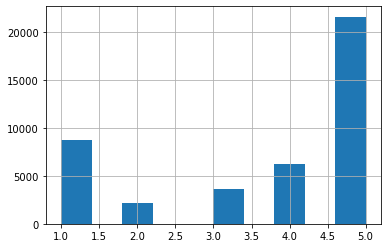

In [16]:
df_reviews.score.hist()

### Logistic Regression

In [17]:
# объеденим ревью с оценками 1-3 в класс 0, с оценками 4-5 в класс 1
# 0 - условно негативные оценки
# 1 - условно положительные оценки

df_reviews['class'] = df_reviews.score.apply(lambda x: 1 if x > 3 else 0)

In [18]:
df_train = df_reviews.sample(frac=0.8, random_state=12)
df_test = df_reviews[~df_reviews.index.isin(df_train.index)].copy()

In [19]:
x_train = df_train['vec'].tolist()
y_train = df_train['class'].tolist()

x_test = df_test['vec'].tolist()
y_test = df_test['class'].tolist()

In [20]:
lr = LogisticRegression(max_iter= 10000, random_state=12, n_jobs=4)

lr.fit(x_train, y_train)

y_preds = lr.predict(x_test)

print("Model score on Training Data = ", lr.score(x_train, y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(x_test, y_test)*100,"%")

Model score on Training Data =  90.35589919140648 %
Model score on Testing Data =  89.42273639475859 %


AUC: 0.8783375703141997


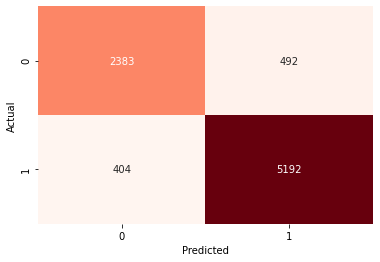

In [21]:
lr_cm = confusion_matrix(y_test, y_preds)

cm = pd.DataFrame(lr_cm, columns=[0,1], index = [0,1])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

sns.heatmap(cm, cbar=False, cmap="Reds", annot=True, fmt='g')

print('AUC:', roc_auc_score(np.array(y_test), y_preds))

#### Проверим пару комментариев

In [22]:
tests = [
     ['Negative', 'Produto muito ruim! Não compro mais nesta loja, a entrega atrasou e custou muito dinheiro!']
    ,['Positive', 'Eu gosto dele e ele realmente correspondeu às expectativas. Comprei barato. Maravilhoso!']
]

for test in tests:
    print('Comment:', test[1])
    print('Class:', test[0])

    transform_test_bad = vec.transform([words_transform(test[1])]).toarray()
    y_preds = lr.predict(transform_test_bad)

    print('Score:','Negative' if y_preds==0 else 'Positive')
    print('===================================================================================================')

Comment: Produto muito ruim! Não compro mais nesta loja, a entrega atrasou e custou muito dinheiro!
Class: Negative
Score: Negative
Comment: Eu gosto dele e ele realmente correspondeu às expectativas. Comprei barato. Maravilhoso!
Class: Positive
Score: Positive


Неплохое качество модели, можно использовать для прогноза оценки по ревью

#### Посмотрим какие слова преобладают в каждом классе

In [23]:
df_words = df_order_reviews.loc[df_order_reviews['review_text']!='',['review_text','review_score']].copy()

df_words['class'] = df_words.review_score.apply(lambda x: 1 if x > 3 else 0)
df_words['text_stemmer_false'] = df_words.review_text.apply(lambda x: words_transform(x, st=False))
df_words['text_stemmer_true'] = df_words.review_text.apply(lambda x: words_transform(x, st=True))

In [24]:
df_words['pred'] = df_words['text_stemmer_true'].apply(lambda x: lr.predict(vec.transform([words_transform(x)]).toarray()))

In [26]:
for num_class in [0,1]:
    bw = df_words.loc[df_words['pred'].str[0]==num_class, 'text_stemmer_true'].str.split().tolist()
    bw = [item for sublist in bw for item in sublist]
    
    ex = df_words.loc[df_words['pred'].str[0]==num_class, 'text_stemmer_false'].str.split().tolist()
    ex = [item for sublist in ex for item in sublist]
    
    dct = pd.DataFrame(columns={'word', 'examples'})
    dct['word'] = bw
    dct['examples'] = ex
    
    gdct = dct.groupby(['word'], as_index=False).agg(list)
    gdct['examples'] = gdct['examples'].apply(lambda x: list(set(x)))
    
    words, values = zip(*Counter(bw).items())
    df = pd.DataFrame(columns={'word', 'count'})
    df['word'] = words
    df['count'] = values
    df['%'] = (df['count']/df['count'].sum()*100).apply(lambda x: round(x,1))
    
    res = pd.merge(df, gdct, on='word', how='outer')
    
    print()
    print('Class: ', 'Negative' if num_class==0 else 'Positive')
    display(res[['count','%','word','examples']].sort_values(by='count', ascending=False).head(15).style.hide_index())
    print('===================================================================================================')


Class:  Negative


count,%,word,examples
11806,7.4,neg,"['negada', 'negaram', 'neguei', 'negação']"
9310,5.9,produt,"['produto', 'produt', 'produti', 'produtor', 'produtos']"
5494,3.5,numer,"['numero', 'numeração', 'numeros']"
5195,3.3,receb,"['recebe', 'recebeu', 'receberá', 'recebidos', 'recebemos', 'recebir', 'recebesse', 'recebidas', 'recebi', 'recebias', 'receba', 'receb', 'recebei', 'recebia', 'recebida', 'recebimento', 'receberei', 'recebido', 'receber', 'recebo', 'recebíamos', 'receberam', 'receberia', 'recebermos', 'recebem', 'recebendo', 'recebê']"
4729,3,entreg,"['entregado', 'entreguem', 'entrega', 'entregariam', 'entregadora', 'entregada', 'entregar', 'entregou', 'entregarão', 'entregando', 'entregues', 'entregara', 'entreg', 'entrege', 'entrego', 'entregaria', 'entregá', 'entregamos', 'entregarem', 'entregadores', 'entregador', 'entregue', 'entregas', 'entregaram', 'entregam']"
4277,2.7,compr,"['comprem', 'comprido', 'comprador', 'comprarei', 'comprando', 'compradora', 'compras', 'comprava', 'compradas', 'comprado', 'compramos', 'compram', 'compriu', 'compr', 'compre', 'compraram', 'compro', 'comprar', 'compra', 'comprimento', 'compraria', 'comprada', 'compradores', 'comprados', 'comprei', 'comprou']"
2356,1.5,vei,"['veio', 'veias', 'vei']"
2149,1.4,cheg,"['chegam', 'chegando', 'cheg', 'chegado', 'chegasse', 'chegamos', 'chegarei', 'chegar', 'chegava', 'chegarem', 'chega', 'chego', 'chegue', 'chegou', 'chegariam', 'chegaria', 'chegara', 'chegavam', 'chegada', 'cheguei', 'chegaram', 'chegará']"
1866,1.2,aind,"['aind', 'ainda', 'ainds']"
1618,1,ped,"['pedisse', 'pedia', 'pedindo', 'pedir', 'pedimos', 'pedidos', 'pedira', 'pedidas', 'pediu', 'pediram', 'pedida', 'pedirei', 'pedido', 'pediria', 'pede', 'pedi']"



Class:  Positive


count,%,word,examples
11695,7.1,produt,"['produtor', 'produt', 'produtos', 'produto']"
7945,4.8,entreg,"['entregado', 'entregava', 'entreguem', 'entrega', 'entregadora', 'entregada', 'entregs', 'entregarei', 'entregou', 'entregar', 'entregando', 'entregarão', 'entregues', 'entregassem', 'entreg', 'entrege', 'entrego', 'entregaria', 'entregá', 'entregaram', 'entregadores', 'entregarem', 'entregador', 'entregue', 'entreguei', 'entregasse', 'entregas', 'entregam']"
7497,4.5,praz,"['praza', 'prazer', 'praz', 'prazos', 'prazo']"
5749,3.5,recom,"['recome', 'recom', 'recomendo']"
5506,3.3,ant,"['anti', 'antos', 'ant', 'ante', 'antes']"
5487,3.3,bom,"['bom', 'bons']"
4463,2.7,cheg,"['chegam', 'chegando', 'cheg', 'chegado', 'chegasse', 'chegar', 'chegava', 'chegarem', 'chega', 'chego', 'chegue', 'chegou', 'chegariam', 'chegaria', 'chegarão', 'chegavam', 'chegada', 'chegassem', 'cheguei', 'cheguem', 'chegaram', 'chegará']"
3706,2.2,ótim,"['ótimo', 'ótimos', 'ótimas', 'ótima']"
3249,2,compr,"['comprem', 'comprido', 'comprador', 'comprarei', 'comprando', 'compradora', 'compras', 'comprarem', 'comprava', 'comprado', 'comprá', 'compramos', 'compriu', 'compr', 'compre', 'compro', 'comprara', 'comprar', 'compra', 'comprimento', 'compraria', 'comprida', 'comprarias', 'comprada', 'compradores', 'comprados', 'comprei', 'comprou']"
2792,1.7,bem,['bem']


Наиболее упортебляемые слова в классе с оценками 1-3 связаны с отказами и неполучением товаров: ``['negada', 'neguei', 'negação', 'negaram']``,``['recebida', 'receb', 'recebidas', 'recebesse', 'receba', 'recebo', 'recebíamos', 'recebias', 'recebeu', 'recebidos', 'receberam', 'recebem', 'recebendo', 'receberia', 'recebia', 'receber', 'recebido', 'receberá', 'recebê', 'recebi', 'recebir', 'recebe', 'receberei', 'recebei', 'recebemos', 'recebimento', 'recebermos']``
задержкой товаров, срывом сроков и т.д.

Наиболее упортебляемые слова в классе с оценками 4-5 связаны с положительными/одобрительными прилагательными: ``['recomendo', 'recome', 'recom'], ['excelentes', 'excelante', 'excelente', 'excelência', 'excele'], ['super', 'supera', 'supar', 'supe'],
['ótimo', 'ótima', 'ótimas', 'ótimos'],`` и положительными словами об сроках доставки: ``['rápidíssima', 'rápidos', 'rápida', 'rápidinho', 'rápido', 'rápidas']``

Можно предположить, что оценка и комментарий зависят от сроков доставки товара.

Далее можно развивать модель: разделить данные на категории товаров, посмотреть кластеры этих товаров или групп, возможно там есть какие-то отличия, проверить зависимости от продавцов, по покупателям можно унифицировать оценки.